In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 constituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library

In [ ]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install pyfolio-reloaded
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


  Using cached peewee-3.17.3-cp310-cp310-linux_x86_64.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.1/354.1 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: peewee
    Found existing installation: peewee 3.17.5
    Uninstalling peewee-3.17.5:
      Successfully uninstalled peewee-3.17.5
✨🍰✨ Everything looks OK!
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-prn84w8h
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-prn84w8h
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit df18dad2f9c3bddabe548f8b516c4798e6a11930
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-s8392nqd/elegantrl_9ea76a6485d641bcbf1d6cdc4fc


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")

<a id='1.3.1'></a>
### 2.3.a. Colab

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from stable_baselines3.common.logger import configure
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

<a id='1.3'></a>
### 2.3.b. Local

In [ ]:
# import sys
# import itertools
# import pandas as pd
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# # matplotlib.use('Agg')
# import datetime
# sys.path.append('D:\\Learning\\University\\UIT\\AI\\Projects\\AI4Finance\\FinRL')

# %matplotlib inline
# from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
# from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
# from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
# from stable_baselines3.common.logger import configure
# from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

# from pprint import pprint

# import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [ ]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [ ]:
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER

TRAIN_START_DATE = '2015-01-01'
TRAIN_END_DATE = '2020-10-01'
TEST_START_DATE = '2020-10-01'
TEST_END_DATE = '2024-06-15'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (70311, 8)


In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2015-01-02,27.847500,27.860001,26.837500,24.435270,212818400,AAPL,4
1,2015-01-02,160.160004,162.589996,158.600006,122.031837,2605400,AMGN,4
2,2015-01-02,93.169998,93.940002,92.139999,80.772018,2437500,AXP,4
3,2015-01-02,131.070007,131.839996,129.089996,113.657227,4294200,BA,4
4,2015-01-02,91.769997,92.370003,90.660004,70.907608,3767900,CAT,4


In [ ]:
df.tail()

,date,open,high,low,close,volume,tic,day
70306,2024-06-14,496.829987,497.850006,491.730011,497.119995,3025400,UNH,4
70307,2024-06-14,270.100006,271.549988,269.269989,270.660004,8501000,V,4
70308,2024-06-14,39.480000,39.840000,39.450001,39.669998,10381800,VZ,4
70309,2024-06-14,15.370000,15.560000,15.160000,15.550000,9013600,WBA,4
70310,2024-06-14,66.540001,67.110001,66.300003,67.019997,12587500,WMT,4


In [ ]:
df.shape

(70311, 8)

In [ ]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2015-01-02,27.847500,27.860001,26.837500,24.435270,212818400,AAPL,4
1,2015-01-02,160.160004,162.589996,158.600006,122.031837,2605400,AMGN,4
2,2015-01-02,93.169998,93.940002,92.139999,80.772018,2437500,AXP,4
3,2015-01-02,131.070007,131.839996,129.089996,113.657227,4294200,BA,4
4,2015-01-02,91.769997,92.370003,90.660004,70.907608,3767900,CAT,4


In [ ]:
print(f"Unique stock: {len(df['tic'].unique())}")

Unique stock: 30


In [ ]:
df['tic'].value_counts()

tic
AAPL    2379
AMGN    2379
AXP     2379
BA      2379
CAT     2379
CRM     2379
CSCO    2379
CVX     2379
DIS     2379
GS      2379
HD      2379
HON     2379
IBM     2379
INTC    2379
JNJ     2379
JPM     2379
KO      2379
MCD     2379
MMM     2379
MRK     2379
MSFT    2379
NKE     2379
PG      2379
TRV     2379
UNH     2379
V       2379
VZ      2379
WBA     2379
WMT     2379
DOW     1320
Name: count, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [ ]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix = True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

[*********************100%%**********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (2378, 8)


Successfully added vix
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2015-01-02,AAPL,27.847500,27.860001,26.837500,24.435270,212818400.0,4.0,0.0,0.0,-66.666667,100.0,17.790001,0.0
1,2015-01-02,AMGN,160.160004,162.589996,158.600006,122.031837,2605400.0,4.0,0.0,0.0,-66.666667,100.0,17.790001,0.0
2,2015-01-02,AXP,93.169998,93.940002,92.139999,80.772018,2437500.0,4.0,0.0,0.0,-66.666667,100.0,17.790001,0.0
3,2015-01-02,BA,131.070007,131.839996,129.089996,113.657227,4294200.0,4.0,0.0,0.0,-66.666667,100.0,17.790001,0.0
4,2015-01-02,CAT,91.769997,92.370003,90.660004,70.907608,3767900.0,4.0,0.0,0.0,-66.666667,100.0,17.790001,0.0
5,2015-01-02,CRM,59.900002,60.430000,58.509998,59.162720,2796400.0,4.0,0.0,0.0,-66.666667,100.0,17.790001,0.0
6,2015-01-02,CSCO,27.860001,28.120001,27.379999,20.657429,22926500.0,4.0,0.0,0.0,-66.666667,100.0,17.790001,0.0
7,2015-01-02,CVX,111.629997,113.000000,110.849998,75.044235,5898800.0,4.0,0.0,0.0,-66.666667,100.0,17.790001,0.0
8,2015-01-02,DIS,94.910004,95.279999,92.849998,87.092415,5865400.0,4.0,0.0,0.0,-66.666667,100.0,17.790001,0.0
9,2015-01-02,GS,195.300003,195.729996,192.699997,161.304306,1877700.0,4.0,0.0,0.0,-66.666667,100.0,17.790001,0.0


In [ ]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2015-10-19 to 2023-04-10

Trading data period: 2023-04-10 to 2024-05-31


In [ ]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
test = data_split(processed_full, TEST_START_DATE,TEST_END_DATE)
print(len(train))
print(len(test))

41963
26999


In [ ]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
1446,2020-09-30,UNH,304.019989,314.519989,303.989990,296.815033,3497300.0,2.0,-1.532067,53.488808,32.701431,14.021989,26.370001,11.137313
1446,2020-09-30,V,200.850006,202.539993,198.889999,194.684479,9157600.0,2.0,-1.204355,50.249864,-61.725012,7.024612,26.370001,11.137313
1446,2020-09-30,VZ,59.459999,59.709999,59.049999,48.131306,16348400.0,2.0,0.081551,54.531246,-38.464422,3.224898,26.370001,11.137313
1446,2020-09-30,WBA,35.549999,36.299999,35.549999,29.730736,6679200.0,2.0,-0.656971,43.321231,-47.938132,17.416241,26.370001,11.137313
1446,2020-09-30,WMT,45.796665,47.246666,45.733334,44.052002,34826400.0,2.0,0.222067,57.093901,49.368855,27.222201,26.370001,11.137313


In [ ]:
test.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2020-10-01,AAPL,117.639999,117.720001,115.830002,114.419518,116120400.0,3.0,-0.311371,55.324100,-11.056530,2.950958,26.700001,13.895158
0,2020-10-01,AMGN,255.070007,258.510010,254.050003,227.129425,2428300.0,3.0,1.203312,56.058366,151.021862,21.709041,26.700001,13.895158
0,2020-10-01,AXP,100.330002,101.480003,99.370003,96.422241,4179300.0,3.0,-0.476114,52.017740,-10.218262,0.173417,26.700001,13.895158
0,2020-10-01,BA,170.149994,172.759995,165.570007,167.860001,30677100.0,3.0,-1.865163,50.028520,34.123745,23.087324,26.700001,13.895158
0,2020-10-01,CAT,149.919998,150.309998,145.649994,135.630310,2157400.0,3.0,0.993800,54.259412,13.900049,12.510686,26.700001,13.895158


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, A2C. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [ ]:
agent = DRLAgent(env = env_train)
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_ensemble = False
if_using_td3 = False
if_using_sac = False

### Agent Training: 3 algorithms (A2C, DDPG, PPO)


### Agent 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=20000) if if_using_a2c else None

In [ ]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

### Agent 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
  trained_ddpg = agent.train_model(model=model_ddpg,
                              tb_log_name='ddpg',
                              total_timesteps=20000) if if_using_ddpg else None

In [ ]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

### Agent 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=20000) if if_using_ppo else None

In [ ]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

In [ ]:
rebalance_window = 63
validation_window = 63

env_ensemble_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

ensemble_agent = DRLEnsembleAgent(df=processed_full,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_ensemble_kwargs) if if_using_ensemble else None

In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 20000,
                 'ppo' : 20000,
                 'ddpg' : 20000
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 None,
                                                 None,
                                                 timesteps_dict) if if_using_ensemble else None

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 2799       |
|    policy_loss        | 130        |
|    reward             | -3.9745946 |
|    std                | 1.01       |
|    value_loss         | 11.9       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 106       |
|    iterations         | 2900      |
|    time_elapsed       | 136       |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -41.4     |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0007    |
|    n_updates          | 2899      |
|    policy_loss        | 34.8      |
|    reward             | 0.0457393 |
|    std                | 1.01      |
|    value_loss      

In [ ]:
df_summary if if_using_ensemble else None

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2020-10-02,2021-01-04,A2C,0.2766,0.242351,0.238572,None,None
1,189,2021-01-04,2021-04-06,A2C,0.423671,0.328415,0.313547,None,None
2,252,2021-04-06,2021-07-06,DDPG,0.116571,0.026522,0.158589,None,None
3,315,2021-07-06,2021-10-04,DDPG,-0.084358,-0.131184,-0.081611,None,None
4,378,2021-10-04,2022-01-03,DDPG,0.171802,0.127206,0.371121,None,None
5,441,2022-01-03,2022-04-04,DDPG,-0.171846,-0.19436,0.009978,None,None
6,504,2022-04-04,2022-07-06,DDPG,-0.181165,-0.225745,-0.176946,None,None
7,567,2022-07-06,2022-10-04,DDPG,-0.192804,-0.237651,-0.1791,None,None
8,630,2022-10-04,2023-01-04,A2C,0.399009,0.240185,0.200584,None,None
9,693,2023-01-04,2023-04-05,A2C,0.087906,-0.152163,-0.157395,None,None


## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [ ]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

count    1447.000000
mean       17.131113
std         8.204512
min         9.140000
25%        12.500000
50%        14.650000
75%        19.000000
max        82.690002
Name: vix, dtype: float64

In [ ]:
insample_risk_indicator.vix.quantile(0.996)

65.64800091552729

In [ ]:
insample_risk_indicator.turbulence.describe()

count    1447.000000
mean       35.106378
std        54.663245
min         0.000000
25%        11.221322
50%        22.331341
75%        38.805433
max       652.619301
Name: turbulence, dtype: float64

In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

447.8815996652415

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
e_trade_gym = StockTradingEnv(df = test, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
test.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2020-10-01,AAPL,117.639999,117.720001,115.830002,114.419518,116120400.0,3.0,-0.311371,55.324100,-11.056530,2.950958,26.700001,13.895158
0,2020-10-01,AMGN,255.070007,258.510010,254.050003,227.129425,2428300.0,3.0,1.203312,56.058366,151.021862,21.709041,26.700001,13.895158
0,2020-10-01,AXP,100.330002,101.480003,99.370003,96.422241,4179300.0,3.0,-0.476114,52.017740,-10.218262,0.173417,26.700001,13.895158
0,2020-10-01,BA,170.149994,172.759995,165.570007,167.860001,30677100.0,3.0,-1.865163,50.028520,34.123745,23.087324,26.700001,13.895158
0,2020-10-01,CAT,149.919998,150.309998,145.649994,135.630310,2157400.0,3.0,0.993800,54.259412,13.900049,12.510686,26.700001,13.895158


In [ ]:
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

FileNotFoundError: [Errno 2] No such file or directory: 'trained_models/agent_a2c.zip'

In [ ]:
train_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_trade_gym) if if_using_a2c else None

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
train_model = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_trade_gym) if if_using_ddpg else None

In [ ]:
train_model = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_trade_gym) if if_using_ppo else None

<a id='7'></a>
# Part 6.5: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [ ]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

### Helper functions for mean returns and variance-covariance matrix

In [ ]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

### Calculate the weights for mean-variance

In [ ]:
train_mvo = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_full, TEST_START_DATE,TEST_END_DATE).reset_index()

In [ ]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[114.42 , 227.129,  96.422, ...,  48.099,  29.689,  45.05 ],
       [110.726, 218.254,  96.689, ...,  47.929,  29.607,  44.238],
       [114.135, 227.681,  98.858, ...,  48.269,  30.31 ,  44.647],
       ...,
       [207.15 , 300.7  , 224.53 , ...,  40.42 ,  15.93 ,  66.73 ],
       [213.07 , 301.08 , 224.04 , ...,  39.77 ,  15.54 ,  66.31 ],
       [214.24 , 298.5  , 222.19 , ...,  39.78 ,  15.45 ,  66.7  ]])

In [ ]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [ 0.123  0.056  0.031  0.061  0.064  0.123  0.051  0.006  0.038  0.027
  0.09   0.058  0.009  0.055  0.043  0.057  0.031  0.08   0.023  0.048
  0.127  0.087  0.05   0.024  0.1    0.092  0.041 -0.025  0.053]
Variance-Covariance matrix of returns
 [[3.433 1.452 1.701 2.154 1.722 2.124 1.838 1.597 1.441 1.94  1.587 1.523
  1.467 2.11  0.978 1.707 0.892 1.144 1.366 1.026 2.23  1.484 0.983 1.188
  1.599 1.858 0.674 1.281 0.899]
 [1.452 2.758 1.313 1.235 1.377 1.503 1.412 1.229 1.09  1.497 1.288 1.193
  1.229 1.589 1.158 1.459 0.803 0.887 1.153 1.398 1.559 1.081 0.967 1.086
  1.522 1.375 0.735 1.335 0.889]
 [1.701 1.313 3.841 3.226 2.127 1.729 1.72  2.419 1.916 2.745 1.835 2.136
  1.785 1.893 1.051 2.725 1.22  1.582 1.649 1.144 1.808 1.788 1.014 1.871
  1.915 2.144 0.802 1.501 0.703]
 [2.154 1.235 3.226 7.006 2.618 2.092 1.939 2.957 2.273 2.933 2.226 2.591
  2.154 2.293 1.193 2.938 1.544 1.814 1.846 1.205 2.047 2.166 1.095 2.209
  2.084 2.316 0.913 1.

### Use PyPortfolioOpt

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([246650.,      0.,      0.,      0.,      0.,  93760.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0., 131800.,      0.,      0., 388570.,
            0.,      0.,      0., 139230.,      0.,      0.,      0.,
            0.])

In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([2173.905,    0.   ,    0.   ,    0.   ,    0.   ,  373.558,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,  653.916,
          0.   ,    0.   , 1908.966,    0.   ,    0.   ,    0.   ,
        469.08 ,    0.   ,    0.   ,    0.   ,    0.   ])

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2020-10-01,1.007468e+06
2020-10-02,9.871284e+05
2020-10-05,1.008451e+06
2020-10-06,9.897193e+05
2020-10-07,1.010051e+06
...,...
2024-06-07,1.725193e+06
2024-06-10,1.725120e+06
2024-06-11,1.765364e+06
2024-06-12,1.790945e+06


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
unique_trade_date = processed_full[(processed_full.date > TEST_START_DATE)&(processed_full.date <= TEST_END_DATE)].date.unique()

In [ ]:
if if_using_ensemble:
  df_trade_date = pd.DataFrame({'datadate':unique_trade_date})
  df_account_value=pd.DataFrame()
  for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
      temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
      df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
  sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
  print('Sharpe Ratio: ',sharpe)
  df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
  df_account_value.head()

Sharpe Ratio:  0.8676573588885474


<Axes: >

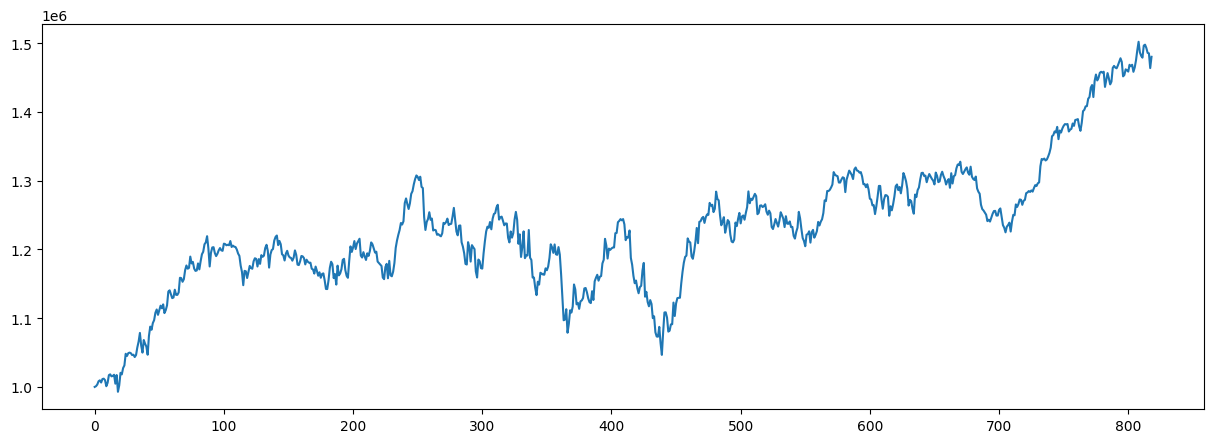

In [ ]:
%matplotlib inline
df_account_value.account_value.plot() if if_using_ensemble else None

[*********************100%%**********************]  1 of 1 completed

==============Compare to DJIA===========
Shape of DataFrame:  (932, 8)


Start date,2021-01-04
End date,2024-04-05
Total months,39
,Backtest
Annual return,12.825%
Cumulative returns,48.018%
Annual volatility,15.271%
Sharpe ratio,0.87
Calmar ratio,0.64
Stability,0.61
Max drawdown,-19.96%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.96,2021-12-29,2022-09-30,2023-04-13,337
1,7.74,2023-09-01,2023-10-23,2023-12-01,66
2,6.38,2021-07-27,2021-09-21,2021-12-08,97
3,5.84,2021-05-10,2021-06-18,2021-07-27,57
4,5.32,2023-05-08,2023-06-14,2023-08-30,83


Stress Events,mean,min,max
Covid,0.05%,-4.16%,3.15%


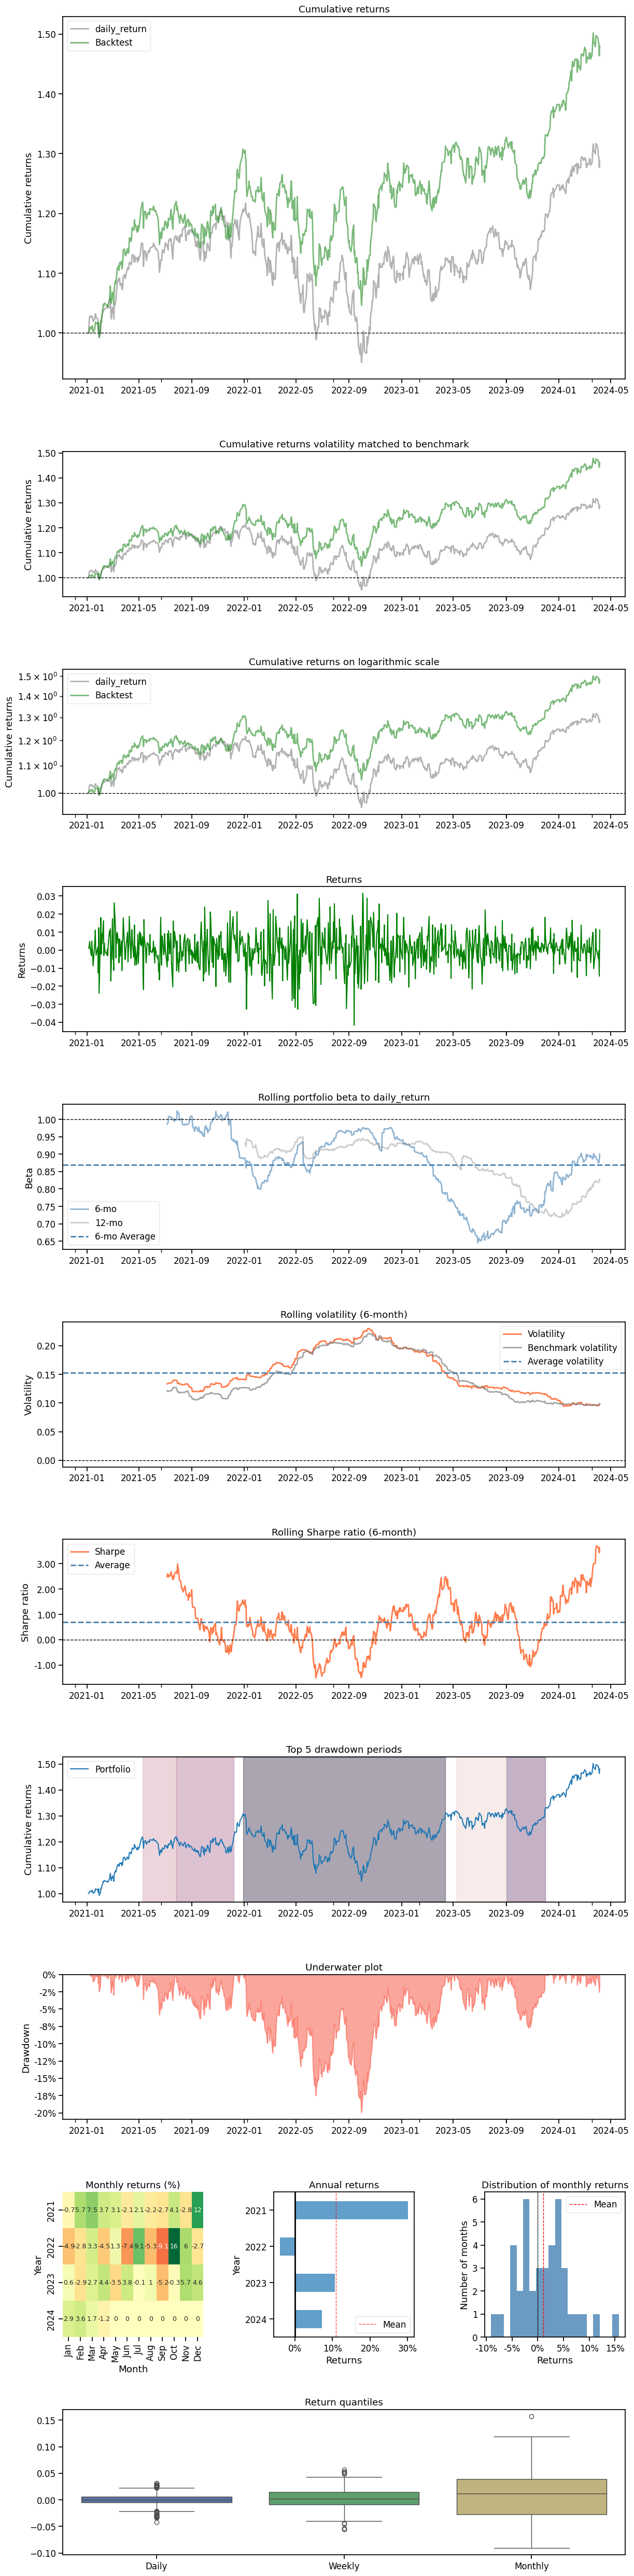

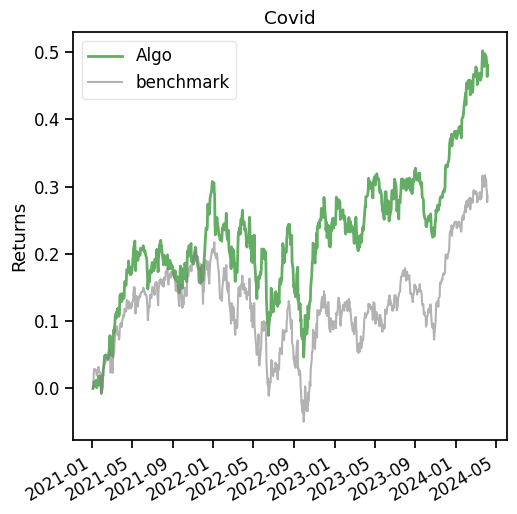

In [ ]:
print("==============Compare to DJIA===========")

# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
if if_using_ensemble:
    backtest_plot(df_account_value,
                    baseline_ticker='^DJI',
                    baseline_start=TEST_START_DATE,
                    baseline_end=TEST_END_DATE)
    plt.show()

In [ ]:
print("==============Compare to DJIA===========")

# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
if if_using_a2c:
    backtest_plot(df_account_value_a2c,
                    baseline_ticker='^DJI',
                    baseline_start=TEST_START_DATE,
                    baseline_end=TEST_END_DATE)
    plt.show()

==============Compare to DJIA===========


In [ ]:
if if_using_ddpg:
    backtest_plot(df_account_value_ddpg,
                    baseline_ticker='^DJI',
                    baseline_start=TEST_START_DATE,
                    baseline_end=TEST_END_DATE)
    plt.show()

In [ ]:
if if_using_ppo:
    backtest_plot(df_account_value_ppo,
                    baseline_ticker='^DJI',
                    baseline_start=TEST_START_DATE,
                    baseline_end=TEST_END_DATE)
    plt.show()

In [ ]:
if if_using_a2c:
  df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
  df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)
  df_account_value_a2c.to_csv("df_account_value_a2c.csv")
if if_using_ddpg:
  df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
  df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
  df_account_value_ddpg.to_csv("df_account_value_ddpg.csv")
if if_using_ppo:
  df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
  df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
  df_account_value_ppo.to_csv("df_account_value_ppo.csv") if if_using_ppo else None
if if_using_ensemble:
  df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
  df_result_ensemble = df_result_ensemble.set_index('date')
  df_result_ensemble.to_csv("df_result_ensemble.csv")
  # print("df_result_ensemble.columns: ", df_result_ensemble.columns)
  # df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
  # print("df_trade_date: ", df_trade_date)
  # df_result_ensemble['date'] = df_trade_date['datadate']
  # df_result_ensemble['account_value'] = df_account_value['account_value']
  # print("df_result_ensemble: ", df_result_ensemble)

#baseline stats
print("\n==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TEST_START_DATE,
        end = TEST_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
if if_using_ensemble:
  df_dji = pd.DataFrame()
  df_dji['date'] = df_account_value['date']
  df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
  df_dji.to_csv("df_dji.csv")
  df_dji = df_dji.set_index(df_dji.columns[0])
  df_dji.to_csv("df_dji+.csv")

result = pd.DataFrame()
# result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
# result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
# result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_dji, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result.columns = ['a2c', 'ddpg', 'ppo', 'mean var', 'dji', 'ensemble']
print(result.head())

# print("result: ", result)
result.to_csv("result.csv")

[*********************100%%**********************]  1 of 1 completed


==============Get Baseline Stats===========
Shape of DataFrame:  (932, 8)
Annual return          0.092540
Cumulative returns     0.387256
Annual volatility      0.146029
Sharpe ratio           0.679837
Calmar ratio           0.421769
Stability              0.354834
Max drawdown          -0.219408
Omega ratio            1.122683
Sortino ratio          0.974154
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.049884
Daily value at risk   -0.018004
dtype: float64
                Mean Var           dji      ensemble
2021-01-04  1.045126e+06  1.000000e+06  1.000000e+06
2021-01-05  1.048035e+06  9.951796e+05  1.001044e+06
2021-01-06  1.032353e+06  1.011926e+06  1.003459e+06
2021-01-07  1.056613e+06  9.984132e+05  1.008256e+06
2021-01-08  1.064617e+06  1.017492e+06  1.009601e+06


<Figure size 1500x500 with 0 Axes>

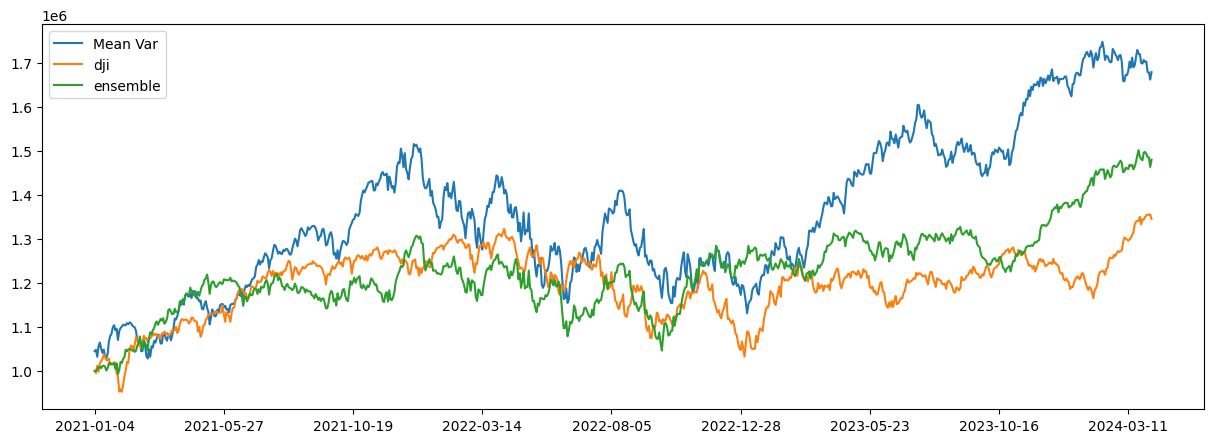

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();